In [1]:
import pandas
import numpy as np
import pandas_profiling as pp

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, Imputer, \
                                  StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.base import TransformerMixin
import cloudpickle as pickle

In [2]:
df = pandas.read_csv("data/train.csv", index_col="PassengerId")
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


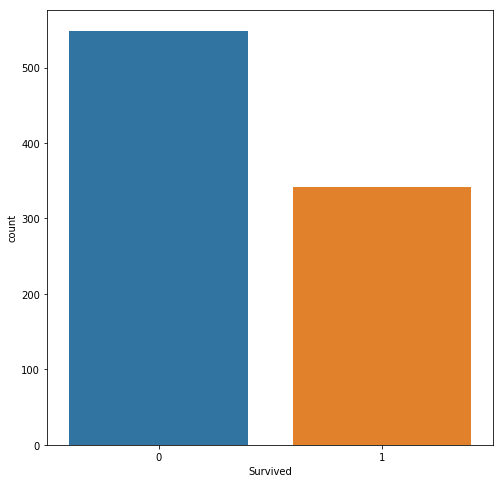

In [3]:
sb.countplot(df.Survived);

decently balanced classes.

In [4]:
len(df)

891

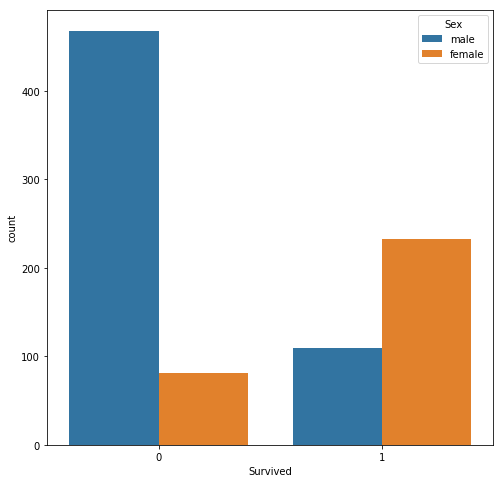

In [5]:
sb.countplot("Survived", data=df, hue="Sex");

as a baseline prediction, sex does decently well...

In [6]:
df.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [7]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

## data encoding

let's start assembling our mapper class.

In [8]:
mapper = DataFrameMapper([], input_df=True, df_out=True)

### target variable

we can retain the target variable as-is, since it's already binarized.  We'll append this back in to the preprocessed CSV.

### Sex

we know sex is useful as a feature, and it's already conveniently binarized with no missing values:

In [9]:
mapper.features.append(("Sex", LabelBinarizer()))

this will use 1 for male, 0 for female.

### Passenger class

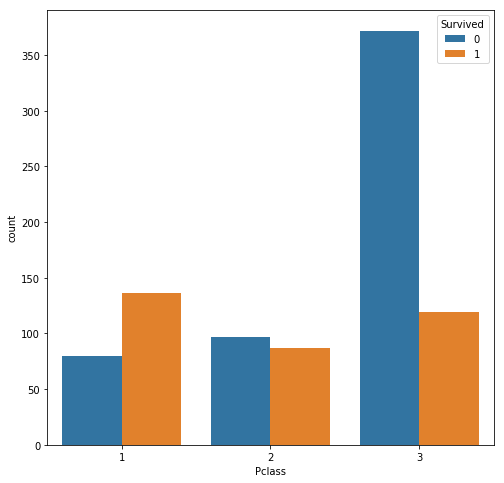

In [10]:
sb.countplot("Pclass", data=df, hue="Survived");

In [11]:
df.groupby("Pclass").Survived.mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

passenger class encodes some useful ordinality already, so let's keep it as-is.

In [12]:
mapper.features.append(("Pclass", None))

### combine class and sex features

In [13]:
df.groupby(['Sex', 'Pclass']).Survived.mean()

Sex     Pclass
female  1         0.968085
        2         0.921053
        3         0.500000
male    1         0.368852
        2         0.157407
        3         0.135447
Name: Survived, dtype: float64

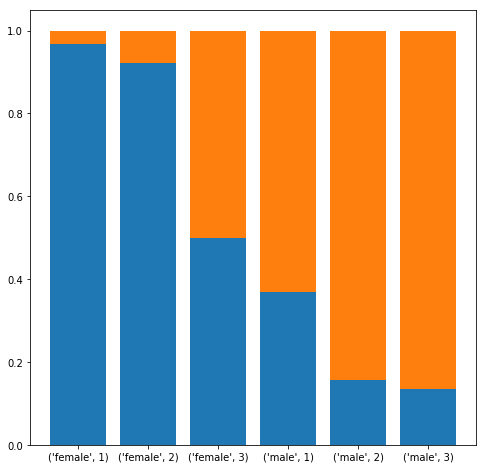

In [14]:
ind = np.arange(6)
survival = df.groupby(['Sex', 'Pclass']).Survived.mean()
plt.bar(ind, survival);
plt.bar(ind, 1. - survival, bottom=survival);
plt.xticks(ind, survival.index);

seems that combining the two gives better ordinal information than `Pclass` alone.

In [15]:
class ClassSexTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def sub(row):
            if row['Sex'] == 'female':
                return row['Pclass']
            else:
                return row['Pclass'] + 3
        return X.apply(sub, axis=1)

In [16]:
mapper.features.append((["Sex", "Pclass"], ClassSexTransformer(), {"alias": "ClassXSex"}))

### parent/child and sibling/spouse relationships:

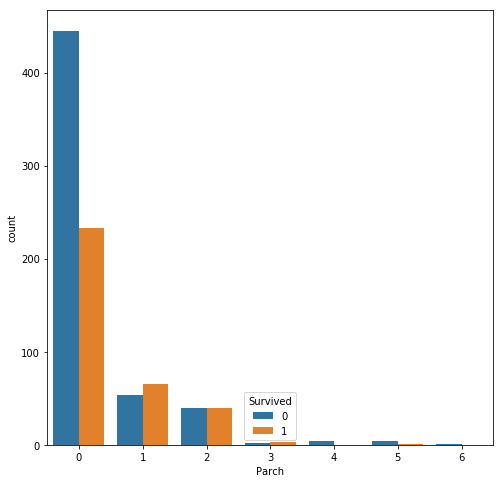

In [17]:
sb.countplot("Parch", data=df, hue='Survived');

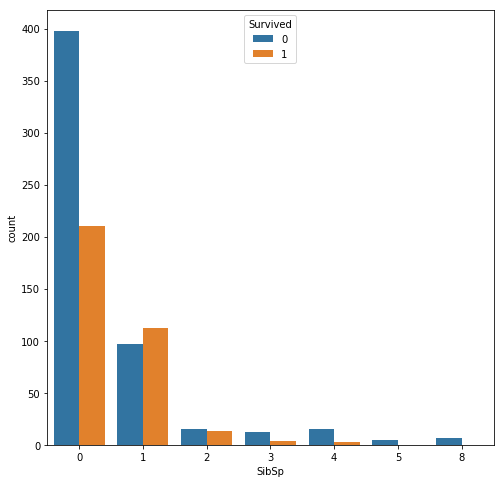

In [18]:
sb.countplot("SibSp", data=df, hue='Survived');

it seems those traveling alone are more likely to die...

In [19]:
df['FamilySize'] = df['SibSp'] + df['Parch']

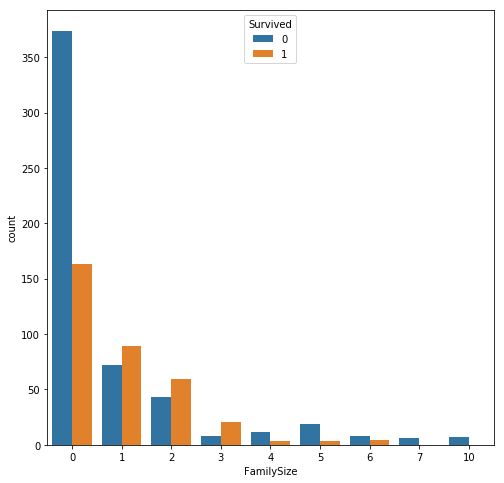

In [20]:
sb.countplot("FamilySize", data=df, hue='Survived');

In [21]:
class FamilySizeImputer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def impute(row):
            val = row['Parch'] + row['SibSp'] 
            if val == 0:
                return "solo"
            elif val < 4:
                return "small"
            else:
                return "large"
        return X.apply(impute, axis=1)

In [22]:
mapper.features.append((["Parch", "SibSp"], [FamilySizeImputer(), LabelBinarizer()], {"alias": "FamilySize"}))

In [23]:
df['FamilyCategory'] = FamilySizeImputer().fit_transform(df)

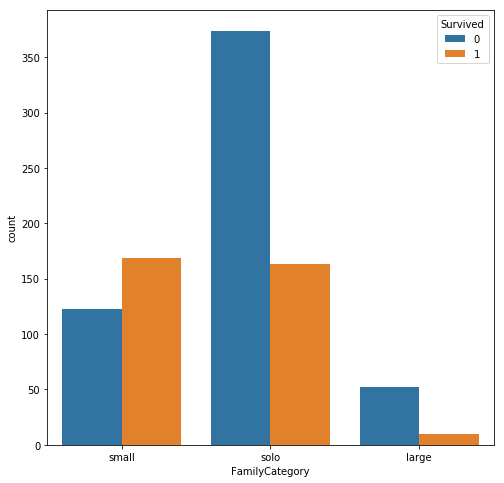

In [24]:
sb.countplot('FamilyCategory', data=df, hue='Survived');

captures the categorical difference that small families are more likely to survive than either solo travelers or large families.

### Ticket encoding

In [25]:
df.Ticket.value_counts()

347082               7
CA. 2343             7
1601                 7
3101295              6
CA 2144              6
347088               6
382652               5
S.O.C. 14879         5
17421                4
PC 17757             4
W./C. 6608           4
4133                 4
LINE                 4
113781               4
349909               4
347077               4
19950                4
113760               4
2666                 4
345773               3
363291               3
29106                3
PC 17572             3
248727               3
347742               3
PC 17582             3
PC 17755             3
239853               3
C.A. 34651           3
24160                3
                    ..
345783               1
695                  1
349234               1
Fa 265302            1
28424                1
112050               1
243880               1
113051               1
C.A. 33595           1
349201               1
SC/AH 29037          1
312993               1
2629       

can we find families traveling on the same ticket?  I wonder if this will be prone to information leakage though...

In [26]:
class TicketSizeImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.ticket_size = X.value_counts()
        return self
    def transform(self, X):
        def impute(val):
            return self.ticket_size.loc[val]
        return X.apply(impute)

In [27]:
df['TicketSize'] = TicketSizeImputer().fit_transform(df.Ticket)

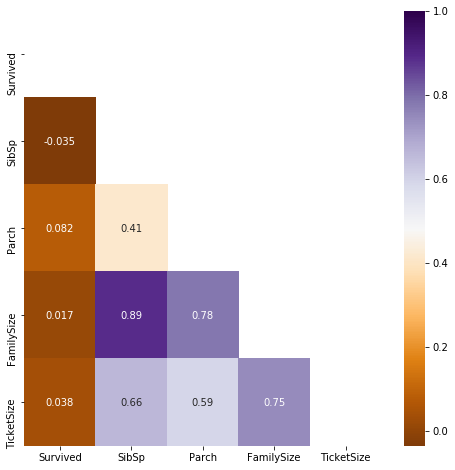

In [28]:
corr = df[["Survived", "SibSp", "Parch", "FamilySize", "TicketSize"]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sb.heatmap(corr, annot=True, mask=mask, cmap="PuOr");

ticket size and family size pretty weakly correlate to survival (as expected by the nonmonotonic trend), but strongly correlate toeach other, like you'd expect.  Let's skip this as a feature.

### fare

/Users/john/python/kaggle-titanic/venv/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


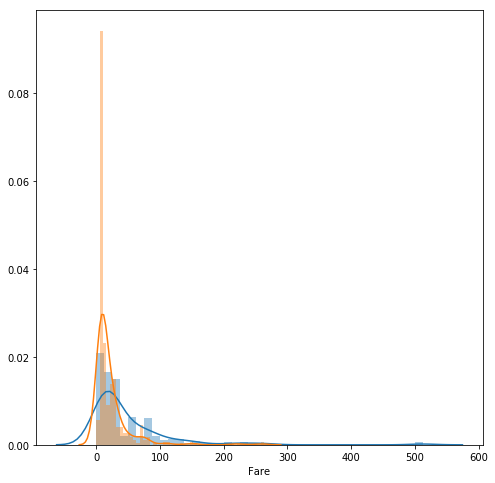

In [29]:
sb.distplot(df[df.Survived == 1].Fare);
sb.distplot(df[df.Survived == 0].Fare);

makes sense, lower-paying fares are less likely to survive... but a lot of that would be captured by the class as well.

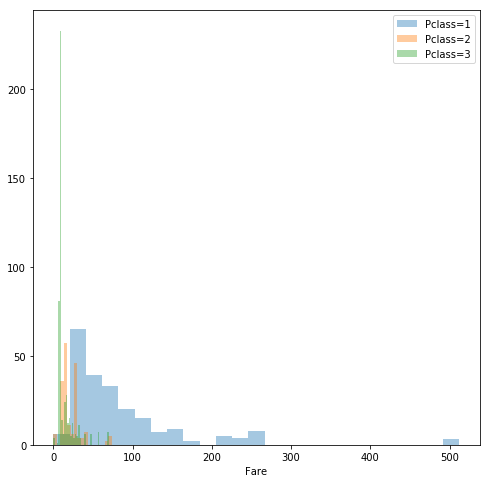

In [30]:
sb.distplot(df[df.Pclass == 1].Fare, kde=False, label='Pclass=1');
sb.distplot(df[df.Pclass == 2].Fare, kde=False, label='Pclass=2');
sb.distplot(df[df.Pclass == 3].Fare, kde=False, label='Pclass=3');
plt.legend();

first off, I suspect this is actually encoding fares for groups of tickets:

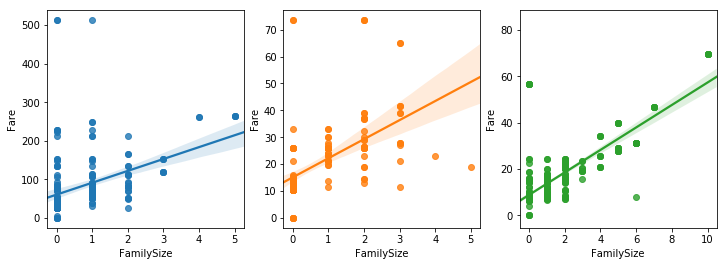

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    sb.regplot(df[df.Pclass == i+1].FamilySize, df[df.Pclass == i+1].Fare, ax=ax);

as suspected, within a single `Pclass` there's a strong upward linear trend in fare vs. family size.  Let's recast this as a fare per person, to normalize it compared to the family size variable.

In [32]:
df[df.Fare == 0]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,FamilyCategory,TicketSize
PassengerId,,,,,,,,,,,,,,
180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,0,solo,4
264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,0,solo,1
272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,0,solo,4
278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,0,solo,3
303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,0,solo,4
414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S,0,solo,3
467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S,0,solo,3
482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S,0,solo,1
598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,0,solo,4


There's also a lot of missing fares, especially for non-survivors.  All seem to be traveling alone, oddly.  Many are missing ages as well.  All embarked from the same place.

Let's impute with the median fare per person for males from their their Pclass... possibly embarkation as well?

In [33]:
df['FarePerPerson'] = df['Fare']/(df['FamilySize'] + 1)

In [34]:
df[df.Fare != 0].groupby(['Pclass', 'Embarked']).size()

Pclass  Embarked
1       C            85
        Q             2
        S           122
2       C            17
        Q             3
        S           158
3       C            66
        Q            72
        S           349
dtype: int64

embarkation counts are all over the place... 

In [35]:
df[df.Fare != 0].groupby(['Pclass', 'Embarked']).FarePerPerson.median()

Pclass  Embarked
1       C           41.085400
        Q           37.500000
        S           30.000000
2       C           12.334733
        Q           12.350000
        S           13.000000
3       C            7.227100
        Q            7.750000
        S            7.854200
Name: FarePerPerson, dtype: float64

but the ranges don't seem too far out from each other.

In [36]:
class SmartFareImputer(TransformerMixin):
    def fit(self, X, y=None):
        tmp = X.copy()
        tmp["FarePerPerson"] = tmp['Fare']/(tmp['SibSp'] + tmp['Parch'] + 1)
        self.fares_per_person = tmp[tmp.Fare != 0].groupby(["Pclass", "Embarked"]).FarePerPerson.median()
        return self
        
    def transform(self, X):
        def impute(row):
            if row.Fare == 0 or row.isnull().loc['Fare']:
                return self.fares_per_person.loc[(row.loc["Pclass"], row.loc['Embarked'])]
            else:
                return row.loc['Fare']/(row.loc['Parch'] + row.loc['SibSp'] + 1)
            
        return X.apply(impute, axis=1)

In [37]:
SmartFareImputer().fit_transform(df)

PassengerId
1       3.625000
2      35.641650
3       7.925000
4      26.550000
5       8.050000
6       8.458300
7      51.862500
8       4.215000
9       3.711100
10     15.035400
11      5.566667
12     26.550000
13      8.050000
14      4.467857
15      7.854200
16     16.000000
17      4.854167
18     13.000000
19      9.000000
20      7.225000
21     26.000000
22     13.000000
23      8.029200
24     35.500000
25      4.215000
26      4.483929
27      7.225000
28     43.833333
29      7.879200
30      7.895800
         ...    
862     5.750000
863    25.929200
864     6.322727
865    13.000000
866    13.000000
867     6.929150
868    50.495800
869     9.500000
870     3.711100
871     7.895800
872    17.518067
873     5.000000
874     9.000000
875    12.000000
876     7.225000
877     9.845800
878     7.895800
879     7.895800
880    41.579150
881    13.000000
882     7.895800
883    10.516700
884    10.500000
885     7.050000
886     4.854167
887    13.000000
888    30.000000
88

In [38]:
mapper.features.append(([ "Pclass", "Embarked", "Fare", "Parch", "SibSp"], SmartFareImputer(), {"alias": "FarePerPerson"}))

### Age

Age will have a similar problem... something like 20% nulls.

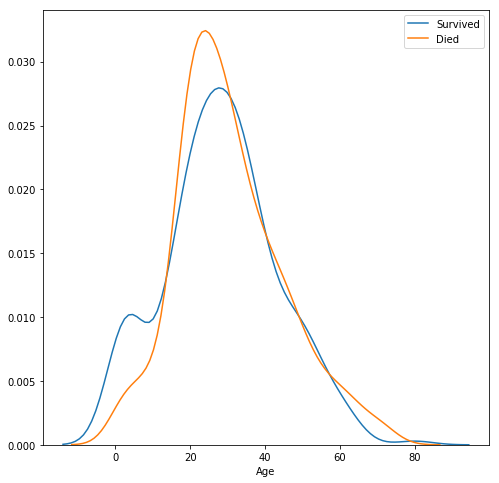

In [39]:
sb.distplot(df[df.Age.notnull() & (df.Survived == 1)].Age, hist=False, label='Survived');
sb.distplot(df[df.Age.notnull() & (df.Survived == 0)].Age, hist=False, label='Died');
plt.legend();

impute with the median age for their sex and Pclass. 

In [40]:
class SmartAgeImputer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        ages = X.groupby(['Sex', 'Pclass']).Age.median()
        
        def impute(row):
            if row.notnull().loc['Age']:
                return row.loc['Age']
            else:
                return ages.loc[(row.loc['Sex'], row.loc['Pclass'])]
            
        return X.apply(impute, axis=1)

In [41]:
mapper.features.append((["Sex", "Pclass", "Age"], SmartAgeImputer(), {"alias": "Age"}))

let's also segment into age brackets - children (under 16), young adults (16-40), and older, corresponding to increased, decreased, and neutral survival likelihood respectively:

In [42]:
class AgeSegmenter(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def segment(val):
            if val <= 16:
                return "child"
            elif val <= 30:
                return "young_adult"
            else:
                return "adult"
        return X.apply(segment)

In [43]:
df['AgeSegment'] = AgeSegmenter().fit_transform(df.Age)

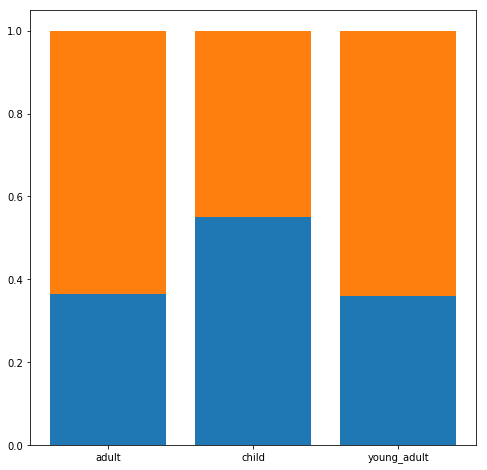

In [44]:
ind = np.arange(3)
survival = df.groupby(["AgeSegment"]).Survived.mean()
plt.bar(ind, survival);
plt.bar(ind, 1. - survival, bottom=survival);
plt.xticks(ind, survival.index);

actually, there doesn't seem to be any break between adults and young adults...

In [45]:
class AgeSegmenter(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def segment(val):
            if val <= 16:
                return "child"
            else:
                return "adult"
        return X.apply(segment)
df['AgeSegment'] = AgeSegmenter().fit_transform(df.Age)

In [46]:
mapper.features.append((['Sex', 'Pclass', 'Age'], [SmartAgeImputer(), AgeSegmenter(), LabelEncoder()], {"alias": "IsChild"}))
mapper.fit_transform(df)

,Sex,Pclass,ClassXSex,FamilySize_large,FamilySize_small,FamilySize_solo,FarePerPerson,Age,IsChild
PassengerId,,,,,,,,,
1,1,3,6,0,1,0,3.625000,22.0,0
2,0,1,1,0,1,0,35.641650,38.0,0
3,0,3,3,0,0,1,7.925000,26.0,0
4,0,1,1,0,1,0,26.550000,35.0,0
5,1,3,6,0,0,1,8.050000,35.0,0
6,1,3,6,0,0,1,8.458300,25.0,0
7,1,1,4,0,0,1,51.862500,54.0,0
8,1,3,6,1,0,0,4.215000,2.0,1
9,0,3,3,0,1,0,3.711100,27.0,0


### Embarkation Point

In [47]:
df.groupby("Embarked").Survived.mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

Cherbourg passengers are much more likely to survive than those from Southampton or Queenstown.  Possibly just a class distinction?

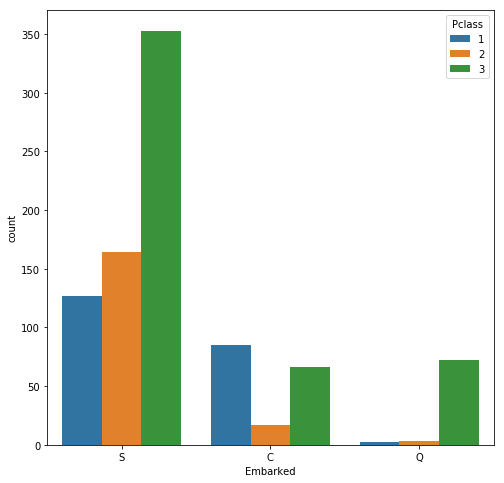

In [48]:
sb.countplot("Embarked", data=df, hue="Pclass");

indeed, Cherbourg has the highest class balance of 1st-class passengers... Southampton is the majority of passengers overall.

In [49]:
df[df.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,FamilyCategory,TicketSize,FarePerPerson,AgeSegment
PassengerId,,,,,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,solo,2,80.0,adult
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,solo,2,80.0,adult


occasional missing values.  Let's impute with "unknown" and binarize.

In [50]:
class CategoricalImputer(TransformerMixin):
    def __init__(self, value=None):
        self.value = value
        super().__init__()
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.fillna(self.value)

In [51]:
mapper.features.append(("Embarked", [CategoricalImputer(value="unknown"), LabelBinarizer()]))

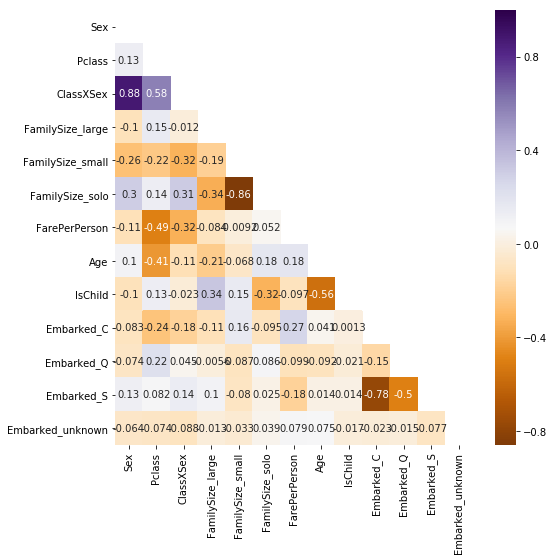

In [52]:
corr = mapper.fit_transform(df).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sb.heatmap(corr, annot=True, mask=mask, cmap='PuOr');

### Passenger name data

let's try extracting titles from names:

In [53]:
df.Name.head(10)

PassengerId
1                               Braund, Mr. Owen Harris
2     Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                Heikkinen, Miss. Laina
4          Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                              Allen, Mr. William Henry
6                                      Moran, Mr. James
7                               McCarthy, Mr. Timothy J
8                        Palsson, Master. Gosta Leonard
9     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
10                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

find the string:
1. after the comma
2. before the period
3. the last word for multi-word titles

In [54]:
df.Name.str.split(',').str.get(1).str.split('.').str.get(0).str.split(' ').str.get(-1).value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Don           1
Lady          1
Mme           1
Jonkheer      1
Ms            1
Countess      1
Sir           1
Capt          1
Name: Name, dtype: int64

looks pretty reasonable.

In [55]:
class TitleExtractor(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.str.split(',').str.get(1).str.split('.').str.get(0).str.split(' ').str.get(-1)

In [56]:
df['Title'] = TitleExtractor().fit_transform(df.Name)

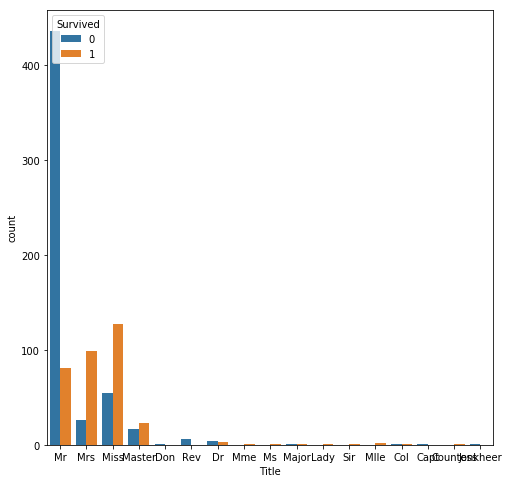

In [57]:
sb.countplot("Title", data=df, hue="Survived");

most of these are quite rare...

In [58]:
df.groupby('Title').Survived.mean().sort_values(ascending=False)

Title
Sir         1.000000
Lady        1.000000
Ms          1.000000
Countess    1.000000
Mme         1.000000
Mlle        1.000000
Mrs         0.792000
Miss        0.697802
Master      0.575000
Major       0.500000
Col         0.500000
Dr          0.428571
Mr          0.156673
Rev         0.000000
Jonkheer    0.000000
Don         0.000000
Capt        0.000000
Name: Survived, dtype: float64

we can munge these into reduced categories, I think.

In [59]:
noble = ("Sir", "Lady", "Countess", "Count")
women = ("Mrs", "Ms", "Miss", "Mme", "Mlle")
men = ("Mr", "Dr", "Col", "Capt", "Major", "Master")
other = ("Don", "Jonkheer", "Rev")

def munge_titles(title):
    if title in noble:
        return "noble"
    elif title in men:
        return "men"
    elif title in women:
        return "women"
    else:
        return "other"
    
df['Title_munged'] = df.Title.apply(munge_titles)

In [60]:
df.groupby("Title_munged").Survived.mean()

Title_munged
men      0.191564
noble    1.000000
other    0.000000
women    0.739550
Name: Survived, dtype: float64

In [61]:
class TitleMunger(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.apply(munge_titles)

In [62]:
mapper.features.append(("Name", [TitleExtractor(), TitleMunger(), LabelBinarizer()], {"alias": "Title"}))

In [63]:
mapper.fit_transform(df)

,Sex,Pclass,ClassXSex,FamilySize_large,FamilySize_small,FamilySize_solo,FarePerPerson,Age,IsChild,Embarked_C,Embarked_Q,Embarked_S,Embarked_unknown,Title_men,Title_noble,Title_other,Title_women
PassengerId,,,,,,,,,,,,,,,,,
1,1,3,6,0,1,0,3.625000,22.0,0,0,0,1,0,1,0,0,0
2,0,1,1,0,1,0,35.641650,38.0,0,1,0,0,0,0,0,0,1
3,0,3,3,0,0,1,7.925000,26.0,0,0,0,1,0,0,0,0,1
4,0,1,1,0,1,0,26.550000,35.0,0,0,0,1,0,0,0,0,1
5,1,3,6,0,0,1,8.050000,35.0,0,0,0,1,0,1,0,0,0
6,1,3,6,0,0,1,8.458300,25.0,0,0,1,0,0,1,0,0,0
7,1,1,4,0,0,1,51.862500,54.0,0,0,0,1,0,1,0,0,0
8,1,3,6,1,0,0,4.215000,2.0,1,0,0,1,0,1,0,0,0
9,0,3,3,0,1,0,3.711100,27.0,0,0,0,1,0,0,0,0,1


note that we've bucketed all the women into a title category... since we have sex x class munged into a single category, I'm inclined to drop each of those from the feature set and instead capture sex alone via the title - this tends to separate high-class from low-class men while preserving the title distinction.

### Cabin/Deck

In [64]:
df.Cabin.isnull().sum()

687

In [65]:
df.Cabin.value_counts().head(20)

B96 B98            4
C23 C25 C27        4
G6                 4
E101               3
F2                 3
C22 C26            3
D                  3
F33                3
C124               2
C65                2
C125               2
B49                2
B28                2
C83                2
B77                2
F G73              2
B57 B59 B63 B66    2
B5                 2
B22                2
B20                2
Name: Cabin, dtype: int64

most passengers don't have a cabin assigned.  We can at least get a deck assignment, though:

In [66]:
def rip_deck(val):
    try:
        return val[0]
    except:
        return "no_cabin"

In [67]:
df['Deck'] = df.Cabin.map(rip_deck)

In [68]:
df.Deck.value_counts()

no_cabin    687
C            59
B            47
D            33
E            32
A            15
F            13
G             4
T             1
Name: Deck, dtype: int64

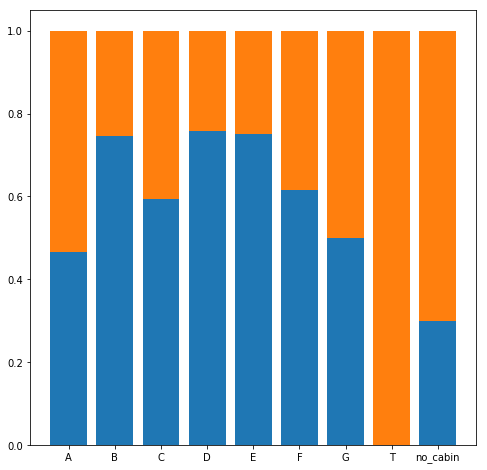

In [69]:
ind = np.arange(9)
survival = df.groupby(["Deck"]).Survived.mean()
plt.bar(ind, survival);
plt.bar(ind, 1. - survival, bottom=survival);
plt.xticks(ind, survival.index);

In [70]:
df.groupby(['Pclass', 'Deck']).Survived.mean()

Pclass  Deck    
1       A           0.466667
        B           0.744681
        C           0.593220
        D           0.758621
        E           0.720000
        T           0.000000
        no_cabin    0.475000
2       D           0.750000
        E           0.750000
        F           0.875000
        no_cabin    0.440476
3       E           1.000000
        F           0.200000
        G           0.500000
        no_cabin    0.235908
Name: Survived, dtype: float64

In [71]:
class DeckTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.map(rip_deck)

In [72]:
mapper.features.append(("Cabin", [DeckTransformer(), LabelBinarizer()], {"alias": "Deck"}))

In [73]:
train = mapper.fit_transform(df)

In [74]:
train.head()

,Sex,Pclass,ClassXSex,FamilySize_large,FamilySize_small,FamilySize_solo,FarePerPerson,Age,IsChild,Embarked_C,...,Title_women,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_no_cabin
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,1,3,6,0,1,0,3.62500,22.0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,1,0,1,0,35.64165,38.0,0,1,...,1,0,0,1,0,0,0,0,0,0
3,0,3,3,0,0,1,7.92500,26.0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,1,1,0,1,0,26.55000,35.0,0,0,...,1,0,0,1,0,0,0,0,0,0
5,1,3,6,0,0,1,8.05000,35.0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [76]:
train['Survived'] = df["Survived"]

In [77]:
test = pandas.read_csv("data/test.csv", index_col="PassengerId")

In [78]:
test = mapper.transform(test)

In [79]:
test.head()

,Sex,Pclass,ClassXSex,FamilySize_large,FamilySize_small,FamilySize_solo,FarePerPerson,Age,IsChild,Embarked_C,...,Title_women,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_no_cabin
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,1,3,6,0,0,1,7.829200,34.5,0,0,...,0,0,0,0,0,0,0,0,0,1
893,0,3,3,0,1,0,3.500000,47.0,0,0,...,1,0,0,0,0,0,0,0,0,1
894,1,2,5,0,0,1,9.687500,62.0,0,0,...,0,0,0,0,0,0,0,0,0,1
895,1,3,6,0,0,1,8.662500,27.0,0,0,...,0,0,0,0,0,0,0,0,0,1
896,0,3,3,0,1,0,4.095833,22.0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [80]:
train.to_csv("data/train_preprocessed.csv")
test.to_csv("data/test_preprocessed.csv")

In [81]:
with open("mapper.pkl", "wb") as wf:
    pickle.dump(mapper, wf)